In [81]:
import pandas as pd
import traceback

from pyspark.sql import SparkSession
from pyspark.sql import Row

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# creating SparkSession
sps = SparkSession.builder.master('local').appName('customer_churn').config("spark.some.config.option", "some-value").getOrCreate()

In [3]:
"""
1) load rdd
2) collect first line
3) filter header
4) convert yes/no by 0/1
5) split
6) transform in Row type
"""

def load_data(nome=''):
    try:
        rdd = sc.textFile(nome)
        first = first = rdd.first()
        rdd2 = rdd.filter(lambda x: first not in x)\
                .map(lambda x: x.replace('"yes"', '1').replace('"no"','0'))\
                .map(lambda x: x.split(',')[1:len(x)])\
                .map(lambda x: Row(state=x[0],
                                 account_length=int(x[1]), 
                                 area_code=x[2], 
                                 international_plan=int(x[3]),     
                                 voice_mail_plan=int(x[4]),    
                                 number_vmail_messages=int(x[5]),   
                                 total_day_minutes=float(x[6]),  
                                 total_day_calls=int(x[7]),    
                                 total_day_charge=float(x[8]), 
                                 total_eve_minutes=float(x[9]), 
                                 total_eve_calls=int(x[10]),   
                                 total_eve_charge=float(x[11]),
                                 total_night_minutes=float(x[12]),  
                                 total_night_calls=int(x[13]),   
                                 total_night_charge=float(x[14]), 
                                 total_intl_minutes=float(x[15]),  
                                 total_intl_calls=int(x[16]),   
                                 total_intl_charge=float(x[17]), 
                                 number_customer_service_calls=int(x[18]),  
                                 churn=int(x[19])))

        return sps.createDataFrame(rdd2) # returns df of Rows
    except Exception as e:
        print(e)
        

In [4]:
dft1 = load_data('projeto4_telecom_treino.csv')

In [5]:
dft2 = load_data('projeto4_telecom_teste.csv')

In [6]:
"""
Encoding string types
"""

ac_indexer = StringIndexer(inputCol="area_code", outputCol="area_code_t").fit(dft1)
st_indexer = StringIndexer(inputCol='state', outputCol='state_t').fit(dft1)

dft1 = ac_indexer.transform(dft1)
dft1 = st_indexer.transform(dft1)

dft2 = ac_indexer.transform(dft2)
dft2 = st_indexer.transform(dft2)

dft1 = dft1.drop(*['area_code','state'])
dft2 = dft2.drop(*['area_code','state'])

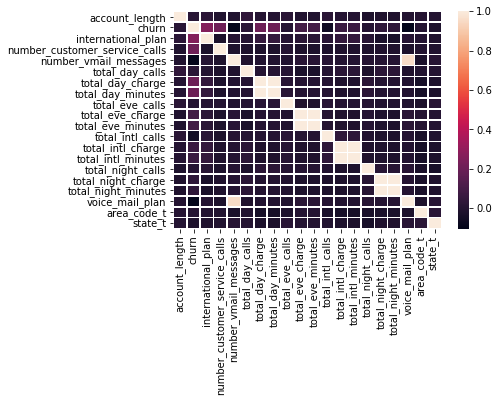

In [147]:
import seaborn as sns
sns.heatmap(dft1.toPandas().corr(), linewidths=0.5)

In [129]:
"""
Verifying correlation and others features
"""

print('Correlations in train:')
lst=[]
for col in dft1.columns:
    lst.append((col, dft1.corr('churn',col)))
sorted(lst, key=lambda tup: tup[1])

Correlations in train:


[('voice_mail_plan', -0.1021481406701469),
 ('number_vmail_messages', -0.08972796983506418),
 ('total_intl_calls', -0.052844335774137816),
 ('state_t', -0.01471772533561556),
 ('area_code_t', 0.004516661668833458),
 ('total_night_calls', 0.006141203007399843),
 ('total_eve_calls', 0.009233131913077921),
 ('account_length', 0.016540742243674286),
 ('total_day_calls', 0.018459311608577066),
 ('total_night_minutes', 0.03549285342127406),
 ('total_night_charge', 0.0354955562405066),
 ('total_intl_minutes', 0.06823877562717737),
 ('total_intl_charge', 0.06825863150391472),
 ('total_eve_charge', 0.09278603942871391),
 ('total_eve_minutes', 0.09279579031259168),
 ('total_day_charge', 0.20515074317015397),
 ('total_day_minutes', 0.2051508292613899),
 ('number_customer_service_calls', 0.20874999878379408),
 ('international_plan', 0.2598518473454819),
 ('churn', 1.0)]

In [133]:
def churn_prev(cols_lst, dft1, dft2, scaler=''):
    try:
        scaler, dft1_, dft2_ = df2vec(dft1, dft2, cols_lst, scaler)

        if scaler=='': #sem escala
            logit_clf = LogisticRegression(labelCol = "churn", featuresCol = "features").fit(dft1_)
        else:
            logit_clf = LogisticRegression(labelCol = "churn", featuresCol = "scaled_features").fit(dft1_)
        
        preds = logit_clf.transform(dft2_)

        avaliador = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "churn", metricName = "accuracy")
        return scaler, avaliador.evaluate(preds)
    except:
        traceback.print_exc()

In [134]:
def df2vec(dft1, dft2, cols, scaler):
    try:
        #sparse vector
        assembler = VectorAssembler(
                    inputCols=[item for item in cols if item!='churn'], # todas menos churn
                    outputCol='features')
        
        df_1 = assembler.transform(dft1).select('churn','features')
        df_2 = assembler.transform(dft2).select('churn','features')
        
        if scaler=='':
            return (scaler, df_1, df_2)
        
        if scaler=='std':
            df_1_scaled = StandardScaler(inputCol='features',
                                         outputCol="scaled_features",
                                         withStd=True, withMean=True).fit(df_1).transform(df_1)

            df_2_scaled = StandardScaler(inputCol='features',
                                 outputCol="scaled_features",
                                 withStd=True, withMean=True).fit(df_2).transform(df_2)
            return (scaler, df_1_scaled.select('churn', 'scaled_features'), df_2_scaled.select('churn', 'scaled_features'))
        
        if scaler=='mimax':
            df_1_scaled = MinMaxScaler(inputCol='features',
                                         outputCol="scaled_features").fit(df_1).transform(df_1)

            df_2_scaled = MinMaxScaler(inputCol='features',
                                 outputCol="scaled_features").fit(df_2).transform(df_2)
            return (scaler, df_1_scaled.select('churn', 'scaled_features'), df_2_scaled.select('churn', 'scaled_features'))
    except:
        traceback.print_exc()

In [27]:
dft1.toPandas().describe()

,account_length,churn,international_plan,number_customer_service_calls,number_vmail_messages,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan,area_code_t,state_t
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,0.144914,0.096910,1.562856,8.099010,100.435644,30.562307,179.775098,100.114311,17.083540,200.980348,4.479448,2.764581,10.237294,100.107711,9.039325,200.872037,0.276628,0.754875,22.536454
std,39.822106,0.352067,0.295879,1.315491,13.688365,20.069084,9.259435,54.467389,19.922625,4.310668,50.713844,2.461214,0.753773,2.791840,19.568609,2.275873,50.573847,0.447398,0.829515,14.544121
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,1.040000,23.200000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,0.000000,1.000000,0.000000,87.000000,24.430000,143.700000,87.000000,14.160000,166.600000,3.000000,2.300000,8.500000,87.000000,7.520000,167.000000,0.000000,0.000000,10.000000
50%,101.000000,0.000000,0.000000,1.000000,0.000000,101.000000,30.500000,179.400000,100.000000,17.120000,201.400000,4.000000,2.780000,10.300000,100.000000,9.050000,201.200000,0.000000,1.000000,22.000000
75%,127.000000,0.000000,0.000000,2.000000,20.000000,114.000000,36.790000,216.400000,114.000000,20.000000,235.300000,6.000000,3.270000,12.100000,113.000000,10.590000,235.300000,1.000000,2.000000,35.000000
max,243.000000,1.000000,1.000000,9.000000,51.000000,165.000000,59.640000,350.800000,170.000000,30.910000,363.700000,20.000000,5.400000,20.000000,175.000000,17.770000,395.000000,1.000000,2.000000,50.000000


In [153]:
lst_prev = [
    ('All features', dft1.columns),
    ('4 best correlations', ['total_day_charge', 'total_day_minutes', 'number_customer_service_calls', 'international_plan']),
    ('4 best correlations - removed same corr.', ['total_eve_minutes', 'total_day_minutes', 'number_customer_service_calls', 'international_plan']),
    ('5 best correlations - removed same corr.', ['total_eve_minutes', 'total_day_minutes', 'number_customer_service_calls', 'international_plan', 'voice_mail_plan']),
    ('Only categorical',['international_plan', 'voice_mail_plan', 'area_code_t', 'state_t']),
    ('All numeric',['number_customer_service_calls', 'number_vmail_messages', 'total_day_calls', 'total_day_minutes','total_eve_calls','total_eve_charge','total_eve_minutes','total_intl_calls','total_intl_charge','total_intl_minutes','total_night_calls','total_night_charge','total_night_minutes']),
    ('All numerical wout correlation each ohter', ['account_length','number_customer_service_calls','total_day_minutes','total_eve_minutes','total_intl_minutes','number_vmail_messages']),
    ('Best numerical', ['number_customer_service_calls','total_day_minutes','total_day_charge','total_eve_minutes','total_eve_charge','total_intl_charge','total_intl_minutes','number_vmail_messages']),
    ('Best numerical wout correlation each ohter', ['number_customer_service_calls','total_day_minutes','total_eve_minutes','total_intl_minutes','number_vmail_messages'])
]


In [154]:
"""
Returns 3 position tuple: scaler, description, accuracy score

scaler='', means that no scaler used.
"""

result=[]

for desc, lst_feat in lst_prev:
    scaler, prev = churn_prev(lst_feat, dft1, dft2)
    result.append((scaler, desc, prev))

In [155]:
for desc, lst_feat in lst_prev:
    scaler, prev = churn_prev(lst_feat, dft1, dft2, 'std')
    result.append((scaler, desc, prev))

In [156]:
for desc, lst_feat in lst_prev:
    scaler, prev = churn_prev(lst_feat, dft1, dft2, 'mimax')
    result.append((scaler, desc, prev))

In [157]:
"""
Return results ordered by score
"""
sorted(result, key=lambda tup: tup[2], reverse=True)    

[('', 'All numeric', 0.8722255548890222),
 ('std', 'All features', 0.8722255548890222),
 ('std', 'All numeric', 0.871625674865027),
 ('', 'All features', 0.8710257948410318),
 ('', '4 best correlations - removed same corr.', 0.8692261547690462),
 ('', 'All numerical wout correlation each ohter', 0.8692261547690462),
 ('std', 'All numerical wout correlation each ohter', 0.8692261547690462),
 ('', 'Best numerical wout correlation each ohter', 0.8686262747450509),
 ('std', '4 best correlations - removed same corr.', 0.8686262747450509),
 ('std', 'Best numerical wout correlation each ohter', 0.8686262747450509),
 ('', 'Best numerical', 0.8680263947210558),
 ('std', 'Best numerical', 0.8680263947210558),
 ('', '4 best correlations', 0.8674265146970606),
 ('std', '4 best correlations', 0.8668266346730654),
 ('', '5 best correlations - removed same corr.', 0.865626874625075),
 ('', 'Only categorical', 0.865626874625075),
 ('std', '5 best correlations - removed same corr.', 0.865626874625075),